# Theoretical Recurrence Interval

__Description__:

__Input__: 

__Output__: 

---
## Load Libraries, Parameters, and File Paths:
### Libraries:

In [1]:
import os
import json
import numpy as np
import pandas as pd
import pathlib as pl
from matplotlib import pyplot as plt

### Parameters:
#### Site specific:

In [2]:
Project_Area = 'Passaic'

root_dir = pl.Path(r'C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\{}'.format(Project_Area))
outputs_dir = root_dir/'Outputs'

#### Project specific (global):

In [3]:
binwidth = 0.1       # [inches]; increment for binning the excess rainfall amount
RI_max = 3000

verbose = True        # Option to display print statements
display_plots = True  # Option to display plots

### File Paths:
#### Weights:

In [4]:
weight_files = []
for f in outputs_dir.glob('*.json'):
    if 'Weights' in f.stem and 'TRI' not in f.stem: 
        weight_files.append(f)       
        print(f)

C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P01_D01_Weights.json
C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P02_D01_Weights.json
C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P03_D01_Weights.json
C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P04_D02_Weights.json
C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P05_D01_Weights.json


#### Forcing:

In [5]:
forcing_files = []
for f in outputs_dir.glob('**/*.json'):
    if 'Forcing' in f.parent.stem:
        forcing_files.append(f)
        print(f)

C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P01_Forcing\Passaic_P01_D01.json
C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P02_Forcing\Passaic_P02_D01.json
C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P03_Forcing\Passaic_P03_D01.json
C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P04_Forcing\Passaic_P04_D01.json
C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P04_Forcing\Passaic_P04_D02.json
C:\Users\sputnam\Desktop\PFRA_Production\Pluvial\Passaic\Outputs\Passaic_P05_Forcing\Passaic_P05_D01.json


---
## Calculate the Theoretical Recurrence Interval:

P01 D01 Theoretical Threshold RI: 12.547947750918667 years
Simulations to include in the Global Scale Test: 78
P02 D01 Theoretical Threshold RI: 10.745434948091837 years
Simulations to include in the Global Scale Test: 69
P03 D01 Theoretical Threshold RI: 17.24258036233912 years
Simulations to include in the Global Scale Test: 65
P04 D01 Theoretical Threshold RI: 30.846241092480426 years
Simulations to include in the Global Scale Test: 49
P04 D02 Theoretical Threshold RI: 12.337329586382904 years
Simulations to include in the Global Scale Test: 66
P05 D01 Theoretical Threshold RI: 13.847688518057556 years
Simulations to include in the Global Scale Test: 68


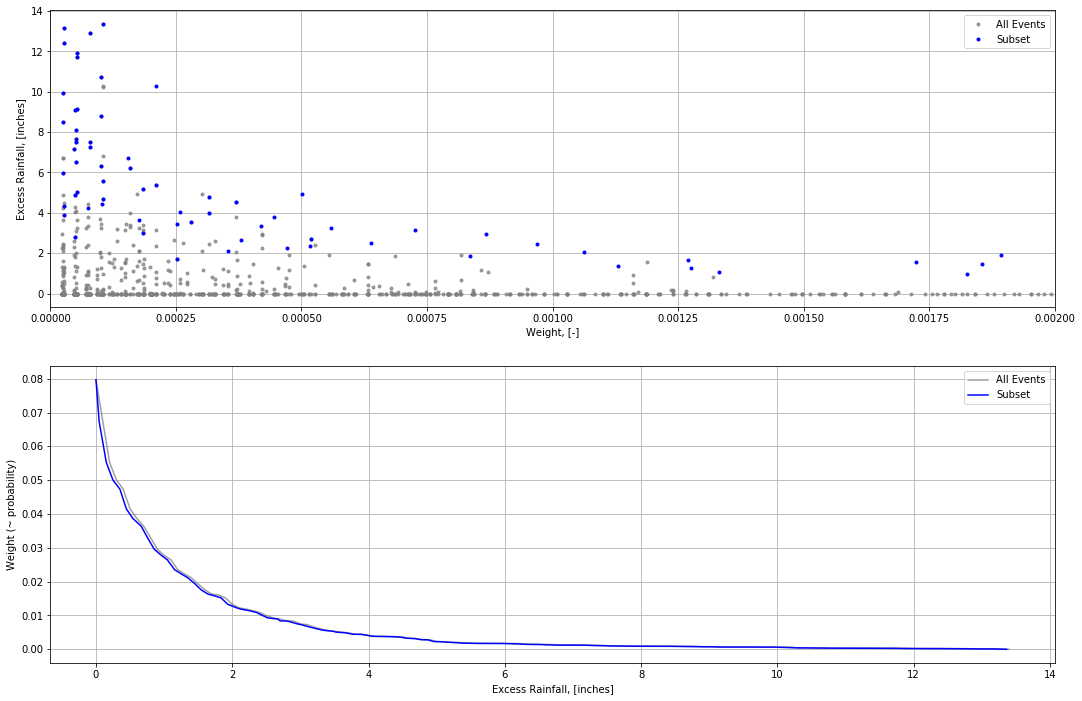

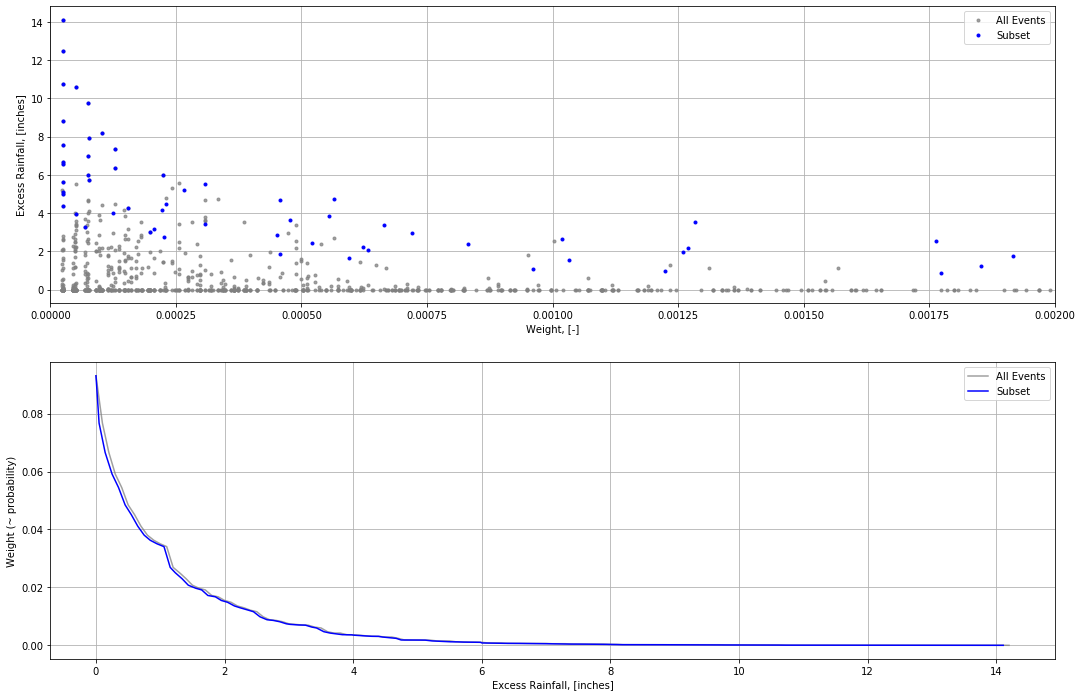

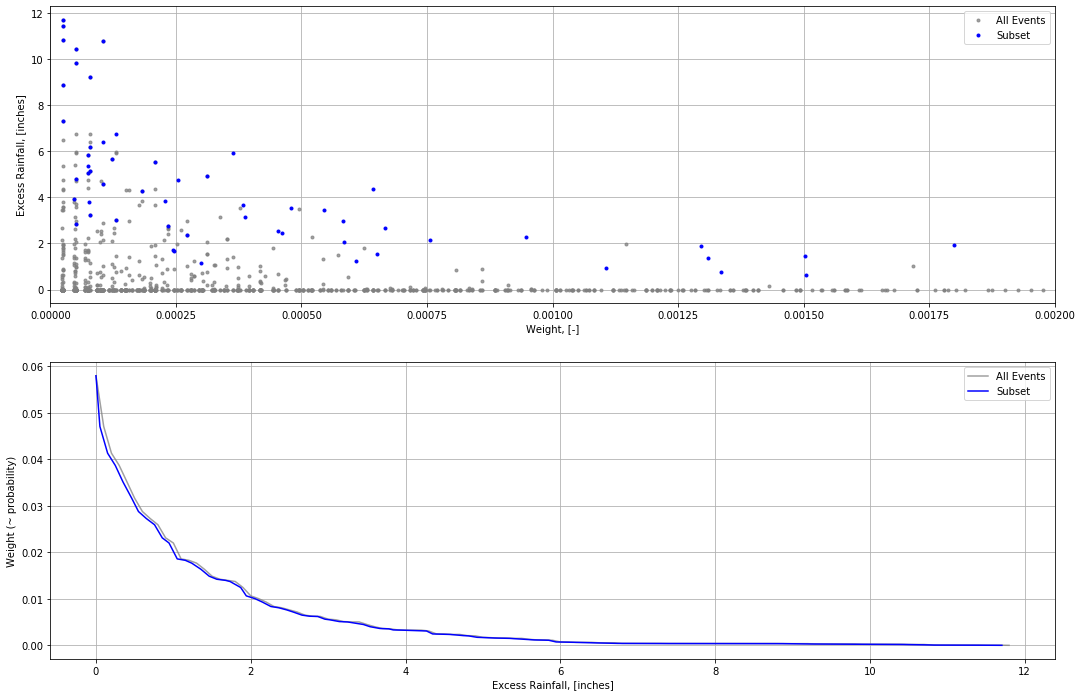

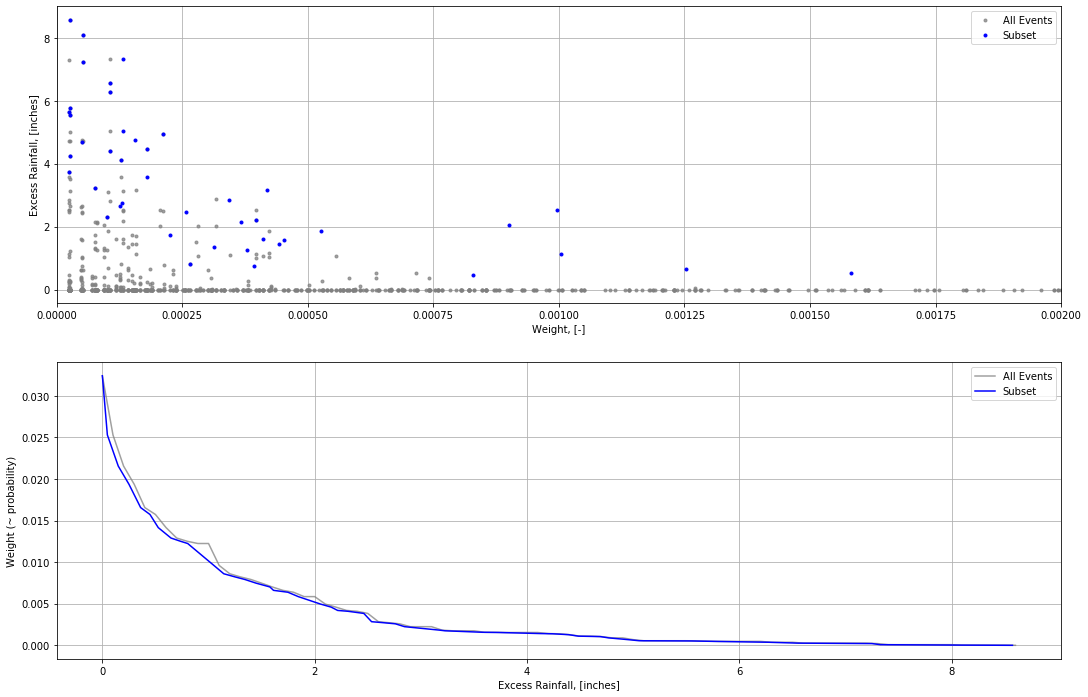

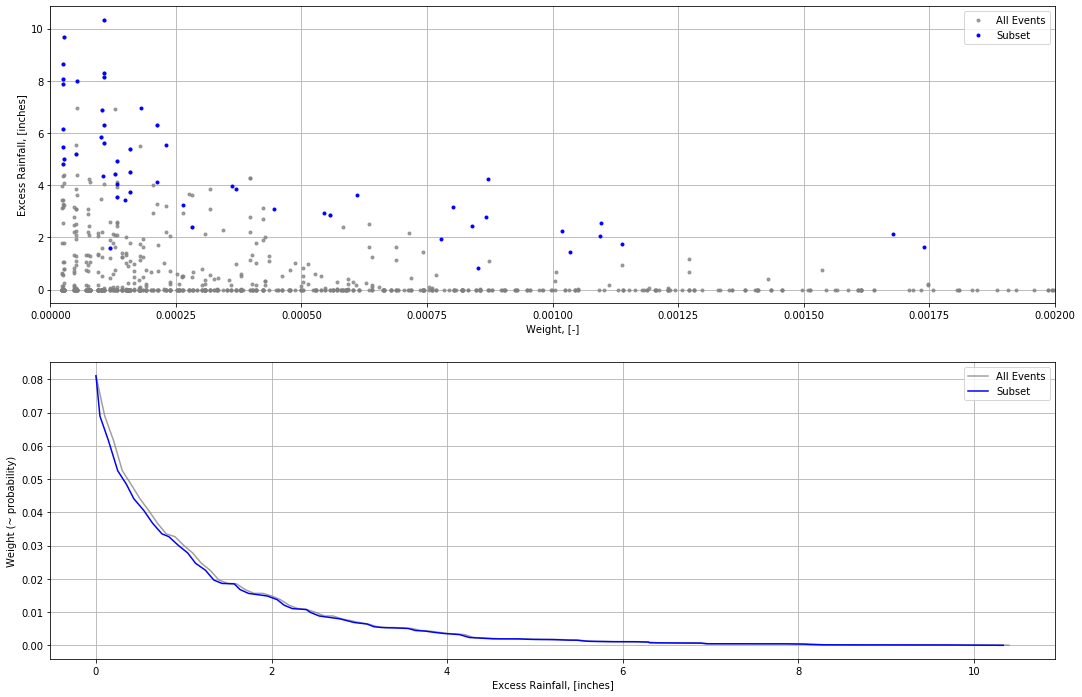

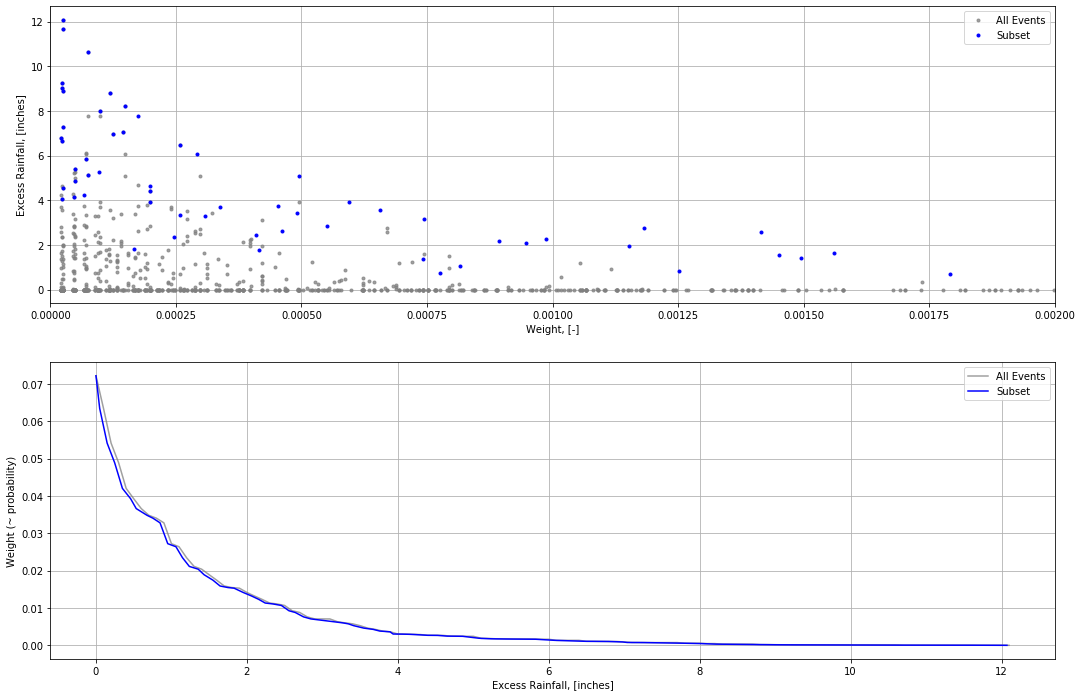

In [6]:
dic = {}
dic_vol = {}
for forcing_file in forcing_files:
    
    _, Pluvial_Model, Domain = forcing_file.stem.split('_')
    
    for w in weight_files:
        if Pluvial_Model in w.stem:
            weight_file = w
            
    with open(forcing_file) as f:
            ff_dic =  json.load(f)
    
    with open(weight_file) as f:
            wt =  json.load(f)  
            
    mainBCN = list(wt['BCName'].keys())[0]
    
    df = pd.DataFrame()
    df['Events'] = list(wt['BCName'][mainBCN].keys())
    df['Weight'] = list(wt['BCName'][mainBCN].values())    
    df = df.set_index('Events')
    for d in list(ff_dic.keys()):
        for k, v in ff_dic[d]['BCName'][Domain].items():
            df.loc[k, 'Volume'] = sum(v)
            df.loc[k, 'Dur'] = d
    df = df.reset_index().sort_values(by=['Volume'], ascending = True).set_index('Events') 
    
    binmin = min(df['Volume'])
    binmax = max(df['Volume'])
    bins = np.arange(binmin, binmax+binwidth, binwidth)
    
    lst = []
    for i, b in enumerate(bins[:]):
        if i==0:
            weight = sum(df[(0.0 == df['Volume'])]['Weight'])
        else:
            weight = sum(df[(bins[i-1]  < df['Volume']) & (df['Volume']<=b)]['Weight'])
        lst.append((b, weight))
    
    binned  = pd.DataFrame()
    binned['Volume'] = [i[0] for i in lst]
    binned['Weight'] = [i[1] for i in lst]
    binned['Cumulative'] = binned['Weight'].cumsum()
    binned['Theoretical RI'] = 1.0/(0.5-binned['Cumulative'])
    
    TTRI = binned.loc[0]['Theoretical RI']
        
    if verbose:
        print('{0} {1} Theoretical Threshold RI: {2} years'.format(Pluvial_Model, Domain, TTRI))
        
    vavg = []
    for i, b in enumerate(binned['Volume']):
        if b==0:
            vavg.append(0.0)
        elif b>0:
            vavg.append((b+binned['Volume'][i-1])/2)
    binned['Vavg'] = vavg 
    
    event = []
    for vavg in binned['Vavg']:
        diff = df['Volume']-vavg
        event.append(diff[diff.abs().argsort()].index[0])
    binned['Event'] = event    
    binned.head()
    
    unique_events = list(set(list(binned['Event'])))
    edf = pd.DataFrame(data = {'Event': unique_events})
    for i, e in enumerate(edf['Event']):
        edf.loc[i, 'Weight'] = sum(binned[binned['Event']==e]['Weight']) 
        edf.loc[i, 'Volume'] = df.loc[e]['Volume']
    edf = edf[edf['Weight']>0.0].copy(deep=True)
    assert np.round(sum(edf['Weight']), 2) == 0.5 , 'Total weight does not equal 0.5 as expected'
    edf = edf.sort_values('Volume').reset_index(drop = True)
    edf['Cumulative'] = edf['Weight'].cumsum()
    print('Simulations to include in the Global Scale Test: {}'.format(edf.shape[0]))
    
    fig, ax = plt.subplots(2, 1, figsize=(18, 12))
    ax[0].plot(df['Weight'], df['Volume'], linestyle = '', marker = '.' , label = 'All Events', color = 'gray', alpha = 0.75)
    ax[0].plot(edf['Weight'], edf['Volume'], linestyle = '', marker = '.', color = 'blue', label = 'Subset')
    ax[0].set_xlabel('Weight, [-]', fontsize = 10)
    ax[0].set_ylabel('Excess Rainfall, [inches]', fontsize=10)
    ax[0].set_xlim([0, 0.002])
    ax[0].legend()
    ax[0].grid()    
    ax[1].plot(binned['Volume'], 0.5 - binned['Cumulative'], linestyle = '-', marker = '', label = 'All Events', color = 'gray', alpha = 0.75)
    ax[1].plot(edf['Volume'], 0.5-edf['Cumulative'], linestyle = '-', marker = '', color = 'blue', label = 'Subset')
    ax[1].set_xlabel('Excess Rainfall, [inches]', fontsize = 10)
    ax[1].set_ylabel('Weight (~ probability)', fontsize=10)
    ax[1].legend()
    ax[1].grid()       
    
    edic = {'BCName':{mainBCN:{}}}
    elist =  []
    for i, e in enumerate(edf['Event']):
        edic['BCName'][mainBCN][e] = edf.loc[i]['Weight']
        elist.append(e)
    with open(outputs_dir/'{0}_{1}_{2}_Weights_TRI.json'.format(Project_Area, Pluvial_Model, Domain), 'w') as f:
        json.dump(edic, f)
        
    df = pd.DataFrame(data = {'Events': elist})
    df = df.set_index('Events')
    df.to_csv(outputs_dir/'{0}_{1}_{2}_Events_TRI.csv'.format(Project_Area, Pluvial_Model, Domain))    

---
## End